# Predict Dow Jones Industrial Average based on Top 25 news in the USA from 2008
Lets try to predict Dow Jones index based on news. To clarify, before I start It is going to be really hard job to try predict stocks because many factors have the impact on it but one of the factor is news from the world! So, let's begin :)

In [26]:
import re
import nltk
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


In [3]:
stock_data=pd.read_csv("upload_DJIA_table.csv")
news_data_1=pd.read_csv("Combined_News_DJIA.csv")
news_data_2=pd.read_csv("RedditNews.csv")

In [4]:
news_data_1.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [5]:
stock_data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [76]:
news_data_2.head()

,Date,News
0,2016-07-01,a 117-year-old woman in mexico city finally re...
1,2016-07-01,imf chief backs athens as permanent olympic host
2,2016-07-01,the president of france says if brexit won so ...
3,2016-07-01,british man who must give police 24 hours' not...
4,2016-07-01,100+ nobel laureates urge greenpeace to stop o...


## Comment
Let's review the datasets used in this analysis. We have three datasets:

1. News_data_1: This dataset contains the top 25 news articles from each day between 2008 and 2016. It includes a "Label" column, which indicates whether the news is classified as positive (1) or negative (0). This dataset will be used to train the model.
2. Stock_Data: This dataset provides daily prices of the Dow Jones Index, which we will use to simulate stock trading actions based on predictions.
3. News_Data_2: This serves as the test set for the model. After training the model on News_Data_1, we will apply it to classify news from this dataset. Based on these predictions, we will simulate actions such as buying, selling, or holding stocks.
This structure allows us to evaluate the model's performance in real-world-like scenarios.

In [6]:
null_mask = news_data_1.isnull().any(axis=1)
null_rows = news_data_1[null_mask]
null_rows

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
277,2009-09-15,1,b'The Church of Scientology won\'t be dissolve...,b'New virus from rats can kill 80 per cent of ...,b'The gruesome spectacle of dolphins being sla...,b'The End of Innocence in Afghanistan: \'The G...,b'France approves Internet piracy bill',b'The Rural Doctors Association says right now...,b'Al Jazeera English - Africa - Shabab to aven...,"b""How Sri Lanka governs through detentions - S...",...,b'In an equine echo of the controversy surroun...,b'UPDATE: 5-New York homes raided in terrorism...,b'Population Growth Impeding Progress on the M...,b'Global Population to Reach 7 Billion by 2011',b'Government Funded Feminist Porn ',b'Can someone enlighten me re:Holy Land disput...,b'Human Rights Watch official suspended for co...,NaN,NaN,NaN
348,2009-12-24,1,b'Woman knocks down Pope Benedict at Christmas...,b'Ugandan President Museveni says he will bloc...,"b""Venezuela's Chavez threatens to kick out car...",b'Woman who knocked down pope had pasta in her...,"b'450 people from 21 countries, including 30 f...",b'Chvez declares Angel Falls is no more: World...,b'Drug tests catch out 10 police (UK)',"b'Once the worlds fourth-largest lake, the Ara...",...,b'Pig farts spark Australia gas scare - I shit...,b'Bin Laden daughter flees to Saudi embassy in...,b'Traumatic Brain Injuries: Growing evidence ...,b'The Pakistan Supreme Court has ordered the P...,"b""Here's a video the Taliban released this mor...",b'Fireworks set off aboard airliner',"b'Five VA men may face terrorism charges, Paki...","b""Ayatollah Montazeri's Legacy: In death he m...",NaN,NaN
681,2011-04-21,1,"Director of ""Restrepo"" and Photographer Chris ...",Everyone within 20km of Fukushima will be forc...,Bahrain: Activist Zaynab Al-Khawaja's letter t...,"More than 80,000 people are claiming incapacit...",Libya: 'mission creep' claims as UK sends in m...,Japan considers banning access to evacuation zone,Chinese oil giant Sinopec has stopped exportin...,6.0-magnitude earthquake strikes off east coas...,...,Russian migration official fired in racism row...,Small amounts of radioactive iodine found in b...,"War photographer, Oscar-nominated film directo...",Effeminate boys are being sent to a special ca...,Japan Government Declares 12-Mile Area Around ...,TEPCO admitted Wednesday that nuclear fuel in ...,Fukushima evacuees face arrest if they return ...,Prince Charles wins some kind of a record,NaN,NaN


In [7]:
most_frequent = news_data_1['Top22'].mode()[0]
news_data_1['Top24'].fillna(most_frequent, inplace=True)
news_data_1['Top25'].fillna(most_frequent, inplace=True)

In [8]:
news_data_1.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    0
Top25    0
dtype: int64

In [9]:
news_data_2.isnull().sum()

Date    0
News    0
dtype: int64

## Comment
The code identifies and handles missing values in news_data_1. Rows with null values are located using isnull(), and the missing values in Top24 and Top25 are filled with the most frequent value from Top22 using mode(). After this, isnull().sum() confirms there are no remaining nulls in news_data_1, ensuring data consistency. Finally, news_data_2 is checked for nulls to verify its completeness.

In [18]:
for col in news_data_1.columns:
    if news_data_1[col].dtype == 'object':
        news_data_1[col] = news_data_1[col].fillna("").apply(lambda x: x.lower().replace(',', ''))

for col in news_data_2.columns:
    if news_data_2[col].dtype == 'object':
        news_data_2[col] = news_data_2[col].fillna("").apply(lambda x: x.lower().replace(',', ''))
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
news_data_1['Date'] = pd.to_datetime(news_data_1['Date'])
news_data_2['Date'] = pd.to_datetime(news_data_2['Date'])
news_data_1['Combined_News'] = news_data_1.iloc[:, 2:].apply(lambda row: ' '.join(row.dropna().values.astype(str)), axis=1)


## Comment
Here, the code preprocesses the datasets for consistency and analysis.
* Text cleaning: In news_data_1 and news_data_2, missing values are replaced with empty strings, text is converted to lowercase, and commas are removed.
* Date formatting: Date columns in all datasets are converted to datetime for proper time-based operations.
* Combined_News: A new column in news_data_1 aggregates all news columns into a single string for each row, simplifying text processing.
These steps ensure the data is clean and ready for modeling.

In [19]:
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(news_data_1['Combined_News']).toarray()
y = news_data_1['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



=== Results for Unigram ===
Model: Logistic Regression
  Accuracy: 0.4799
  AUC-ROC: 0.4829
  Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.49      0.45       171
           1       0.55      0.48      0.51       227

    accuracy                           0.48       398
   macro avg       0.48      0.48      0.48       398
weighted avg       0.49      0.48      0.48       398

  Confusion Matrix:
[[ 83  88]
 [119 108]]

Model: Random Forest
  Accuracy: 0.5126
  AUC-ROC: 0.4675
  Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.41      0.42       171
           1       0.57      0.59      0.58       227

    accuracy                           0.51       398
   macro avg       0.50      0.50      0.50       398
weighted avg       0.51      0.51      0.51       398

  Confusion Matrix:
[[ 70 101]
 [ 93 134]]

Model: Naive Bayes
  Accuracy: 0.4899
  AUC-ROC: 0.4653
 

/opt/anaconda3/envs/First_Assignment/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [23:19:51] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
  Accuracy: 0.4975
  AUC-ROC: 0.5005
  Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.44      0.43       171
           1       0.56      0.54      0.55       227

    accuracy                           0.50       398
   macro avg       0.49      0.49      0.49       398
weighted avg       0.50      0.50      0.50       398

  Confusion Matrix:
[[ 75  96]
 [104 123]]


=== Results for Bigram ===
Model: Logistic Regression
  Accuracy: 0.4899
  AUC-ROC: 0.5010
  Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.47      0.44       171
           1       0.56      0.51      0.53       227

    accuracy                           0.49       398
   macro avg       0.49      0.49      0.49       398
weighted avg       0.50      0.49      0.49       398

  Confusion Matrix:
[[ 80  91]
 [112 115]]

Model: Random Forest
  Accuracy: 0.5000
  AUC-ROC: 0.5102
  Clas

/opt/anaconda3/envs/First_Assignment/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [23:20:30] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBoost
  Accuracy: 0.4623
  AUC-ROC: 0.4553
  Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.41      0.40       171
           1       0.53      0.50      0.52       227

    accuracy                           0.46       398
   macro avg       0.46      0.46      0.46       398
weighted avg       0.47      0.46      0.46       398

  Confusion Matrix:
[[ 70 101]
 [113 114]]


Comparing the result for unigram and bigram models:
                    Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
3  Support Vector Machine  0.520101   0.562937  0.709251  0.627680  0.507458   
1           Random Forest  0.512563   0.570213  0.590308  0.580087  0.467488   
4                 XGBoost  0.497487   0.561644  0.541850  0.551570  0.500528   
2             Naive Bayes  0.489950   0.556075  0.524229  0.539683  0.465312   
0     Logistic Regression  0.479899   0.551020  0.475771  0.510638  0.482907   
3  Support Vector M

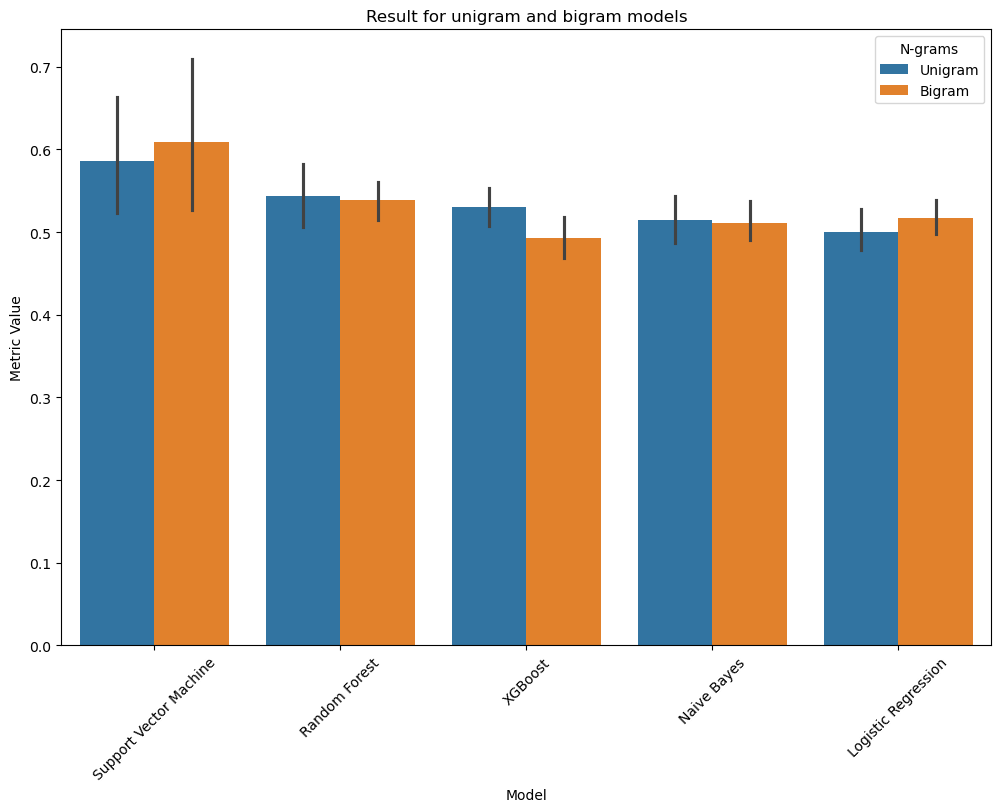

In [77]:
vectorizer_unigram = CountVectorizer(max_features=5000, stop_words="english", ngram_range=(1, 1))
vectorizer_bigram = CountVectorizer(max_features=5000, stop_words="english", ngram_range=(2, 2))

X_unigram = vectorizer_unigram.fit_transform(news_data_1["Combined_News"]).toarray()
X_bigram = vectorizer_bigram.fit_transform(news_data_1["Combined_News"]).toarray()

X_train_uni, X_test_uni, y_train_uni, y_test_uni = train_test_split(
    X_unigram, y, test_size=0.2, random_state=42
)
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(
    X_bigram, y, test_size=0.2, random_state=42
)

def evaluate_models(X_train, X_test, y_train, y_test, ngram_type):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "Support Vector Machine": SVC(probability=True, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    }

    print(f"\n=== Results for {ngram_type} ===")
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": report["1"]["precision"],
            "Recall": report["1"]["recall"],
            "F1-Score": report["1"]["f1-score"],
            "AUC-ROC": auc,
        })

        print(f"Model: {name}")
        print(f"  Accuracy: {acc:.4f}")
        if auc is not None:
            print(f"  AUC-ROC: {auc:.4f}")
        print(f"  Classification Report:\n{classification_report(y_test, y_pred)}")
        print(f"  Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

    return pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
results_uni = evaluate_models(X_train_uni, X_test_uni, y_train_uni, y_test_uni, "Unigram")

results_bi = evaluate_models(X_train_bi, X_test_bi, y_train_bi, y_test_bi, "Bigram")

print("\nComparing the result for unigram and bigram models:")
results_uni["N-gram"] = "Unigram"
results_bi["N-gram"] = "Bigram"
comparison_df = pd.concat([results_uni, results_bi])
print(comparison_df)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=comparison_df.melt(id_vars=["Model", "N-gram"]),
    x="Model",
    y="value",
    hue="N-gram",
)
plt.title("Result for unigram and bigram models")
plt.xticks(rotation=45)
plt.ylabel("Metric Value")
plt.legend(title="N-grams")
plt.show()

##  Comment
My code evaluates five machine learning models:

1. Logistic Regression (linear classifier, efficient for text data),
2. Random Forest (ensemble of decision trees, reduces overfitting),
3. Naive Bayes (probabilistic, assumes feature independence),
4. SVM (finds optimal hyperplane for classification, robust to high-dimensional data).
5. XGBoost (gradient boosting, high-performance iterative approach).


The models are assessed using accuracy, which measures the proportion of correctly predicted labels. Additionally, other metrics like precision, recall, F1-score, and AUC-ROC are used for a more comprehensive evaluation:

* Precision assesses the correctness of positive predictions.
* Recall evaluates the model's ability to capture all actual positives.
* F1-score balances precision and recall.
* AUC-ROC measures the model's ability to discriminate between classes.

Here we have the analysis of the output: 
1. Support Vector Machine (SVM) is the top-performing model, achieving the highest accuracy (52.01% for unigrams and 53.77% for bigrams) and recall, especially with bigrams.
2. Random Forest performs reasonably well (51.25% accuracy for unigrams) but shows minimal improvement with bigrams.
3. Logistic Regression and Naive Bayes deliver similar results, with accuracies around 48%-49%, and their recall is weaker compared to SVM.
4. XGBoost has the lowest accuracy (46%-49%), indicating it may not handle sparse text features effectively.
5. Bigram features slightly improve results for some models (e.g., SVM), but overall, the AUC-ROC values (~0.50) highlight difficulties in class separation.
Further feature engineering and hyperparameter tuning are necessary to boost model performance.

To sum up the results are pretty bad unfortunately, because the models struggle with sparse and high-dimensional text data, likely due to insufficient feature representation or lack of advanced preprocessing like stemming, lemmatization, or sentiment analysis.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
if isinstance(X, (pd.Series, np.ndarray)):
    X1 = X.tolist()
else:
    X1 = X

X1 = [" ".join(str(x) for x in row) if isinstance(row, (list, tuple)) else str(row) for row in X1]
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X1, y, test_size=0.2, random_state=42)
advancedvectorizer = TfidfVectorizer(
    min_df=1,  
    max_df=0.95, 
    max_features=200000,
    ngram_range=(1, 2)  
)
X_train_tfidf = advancedvectorizer.fit_transform(X_train_tf)
X_test_tfidf = advancedvectorizer.transform(X_test_tf)

advancedmodel_tfid = LogisticRegression()
advancedmodel_tfid.fit(X_train_tfidf, y_train_tf)

y_pred = advancedmodel_tfid.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test_tf, y_pred))
print("Classification Report:\n", classification_report(y_test_tf, y_pred))

Accuracy: 0.5703517587939698
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.01      0.02       171
           1       0.57      0.99      0.72       227

    accuracy                           0.57       398
   macro avg       0.54      0.50      0.37       398
weighted avg       0.54      0.57      0.42       398



## Comment
This code leverages TfidfVectorizer to preprocess text data, converting it into a TF-IDF feature matrix that captures the importance of terms relative to their frequency across documents. The vectorizer is configured to consider both unigrams and bigrams (ngram_range=(1, 2)) and excludes overly frequent or rare terms (min_df=1, max_df=0.95) to balance feature informativeness and noise. The Logistic Regression model is trained and tested on these features, achieving an accuracy of 57%.

However, while the TF-IDF approach better highlights important terms, the model's performance is still limited by imbalanced class distributions and the potential lack of deeper semantic understanding in text representation. The classification report reflects this, with significantly better recall for class 1 (99%) but poor performance for class 0 (precision and recall both around 1-2%). This suggests that the model is overfitting to the dominant class, failing to generalize effectively to the minority class.

In [75]:
y_pred_prob = advancedmodel_tfid.predict_proba(X_new_tfidf)
print(y_pred_prob)
buy_threshold = 0.57
sell_threshold = 0.57

grouped_news['Prediction1'] = ['buy' if prob[1] >= buy_threshold else ('sell' if prob[0] >= sell_threshold else 'neutral') for prob in y_pred_prob]

print(grouped_news[['Date', 'News', 'Prediction1']])

merged_data = pd.merge(stock_data, grouped_news, on='Date', how='left')

portfolio = 10000  
stock_position = 0  
short_position = 0  


for i, row in merged_data.iterrows():
    action = row['Prediction1']
    price = row['Close']

    if action == 'buy' and portfolio >= price:
        stock_position = portfolio / price  
        portfolio = 0  
        print(f"Buying at {price}, portfolio now: {portfolio}")
    elif action == 'sell' and stock_position > 0:
        portfolio = stock_position * price 
        stock_position = 0  
        print(f"Selling at {price}, portfolio now: {portfolio}")
    
print(f"Final portfolio value: {portfolio}")

[[0.65087844 0.34912156]
 [0.47289889 0.52710111]
 [0.36858581 0.63141419]
 ...
 [0.47289889 0.52710111]
 [0.47289889 0.52710111]
 [0.53014317 0.46985683]]
           Date                                               News Prediction1
0    2008-06-08  b'nim chimpsky: the tragedy of the chimp who t...        sell
1    2008-06-09  b'united states quits human rights council' b"...     neutral
2    2008-06-10  b'oil shortage a myth says industry insider' b...         buy
3    2008-06-11  b'bbc uncovers lost iraq billions' b'war crimi...     neutral
4    2008-06-12  b'did us attack pakistan last night? "pakistan...     neutral
...         ...                                                ...         ...
2938 2016-06-27  barclays and rbs shares suspended from trading...     neutral
2939 2016-06-28  2500 scientists to australia: if you want to s...        sell
2940 2016-06-29  explosion at airport in istanbul yemeni former...     neutral
2941 2016-06-30  jamaica proposes marijuana dispensers

## Comment
The code uses a prediction model to make investment decisions based on news from news_data_2. After obtaining the prediction probabilities using predict_proba, it assigns actions (buy, sell, neutral) based on defined thresholds. Then, based on these actions, it decides whether to buy or sell stocks, and the result is tracked in the portfolio variable. Although the model has low accuracy when analyzing news, a profit of 1546 dollars was achieved. 

Insights:
Despite the model's poor performance in predicting news, a profit of 1546 units was made, emphasizing the difficulty of analyzing complex texts. To improve prediction accuracy, more advanced models and larger datasets are needed for training. And of course do not use this as a financial advice :)